## Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, export_text, export_graphviz
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### Download dataset

In [3]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

In [4]:
data = pd.read_csv(url)

In [5]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Preparing the dataset

- First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

In [6]:
df = data[data.ocean_proximity.isin(['<1H OCEAN','INLAND'])]

#### Data Exploration

In [7]:
df.shape

(15687, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


In [9]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
longitude,15687.0,NaN,NaN,NaN,-119.217442,1.78038,-124.14,-121.07,-118.37,-117.99,-114.31
latitude,15687.0,NaN,NaN,NaN,35.467307,2.066387,32.61,33.94,34.16,37.34,41.95
housing_median_age,15687.0,NaN,NaN,NaN,27.188118,12.057128,1.0,17.0,27.0,36.0,52.0
total_rooms,15687.0,NaN,NaN,NaN,2665.677312,2257.672743,2.0,1441.0,2118.0,3172.0,39320.0
total_bedrooms,15530.0,NaN,NaN,NaN,541.244688,435.650018,2.0,295.0,432.0,645.0,6445.0
population,15687.0,NaN,NaN,NaN,1466.317205,1180.389908,3.0,802.0,1195.0,1777.0,35682.0
households,15687.0,NaN,NaN,NaN,500.916491,392.759399,2.0,278.0,406.0,602.0,6082.0
median_income,15687.0,NaN,NaN,NaN,3.804019,1.857158,0.4999,2.5208,3.4688,4.6862,15.0001
median_house_value,15687.0,NaN,NaN,NaN,191943.020017,108801.07762,14999.0,111300.0,166900.0,241100.0,500001.0
ocean_proximity,15687,2,<1H OCEAN,9136,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Checking for null values and duplication
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Filling null values

In [11]:
df.fillna(0, inplace=True)

In [12]:
# Checking for null values and duplication
df.isnull().sum().sum()

0

In [13]:
df.duplicated().sum()

0

#### Apply the log tranform to median_house_value

In [14]:
df.median_house_value = np.log1p(df.median_house_value)

In [15]:
df.median_house_value.head()

701    12.973866
830    12.287657
859    12.419574
860    12.554971
861    12.287196
Name: median_house_value, dtype: float64

### Splitng dataset

In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train.median_house_value
y_val = df_val.median_house_value
y_test = df_test.median_house_value

In [19]:
del df_train['median_house_value']
del df_val['median_house_value']
del  df_test['median_house_value']

### DictVectorizer

In [20]:
dv = DictVectorizer(sparse=False)

In [21]:
train_dict = df_train.to_dict(orient='records')
train_val = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(train_val)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* **`ocean_proximity`**
* `total_rooms`
* `latitude`
* `population`

In [22]:
dt = DecisionTreeRegressor(max_depth=1)

In [23]:
dt_model = dt.fit(X_train, y_train)

In [24]:
print(export_text(dt_model, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



#### Answer -> **ocean_proximity**

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* **0.245**
* 0.545
* 0.845

In [25]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [26]:
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [27]:
y_pred_rfr = rfr.predict(X_val)

In [28]:
np.sqrt(mean_squared_error(y_val, y_pred_rfr))

0.24472888684076874

#### Anwser -> **0.245**

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- **160**

In [29]:
scores = []
for i in range(10, 201, 10):
    temp_rfr = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    temp_model_rfr = temp_rfr.fit(X_train,y_train)
    y_pred_temp = temp_model_rfr.predict(X_val)
    scores.append((i, np.sqrt(mean_squared_error(y_val, y_pred_temp))))  

In [30]:
df_scores_result = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores_result

,n_estimators,rmse
0,10,0.244729
1,20,0.238247
2,30,0.236230
3,40,0.234584
4,50,0.234490
5,60,0.234146
6,70,0.234152
7,80,0.234313
8,90,0.234303
9,100,0.234156


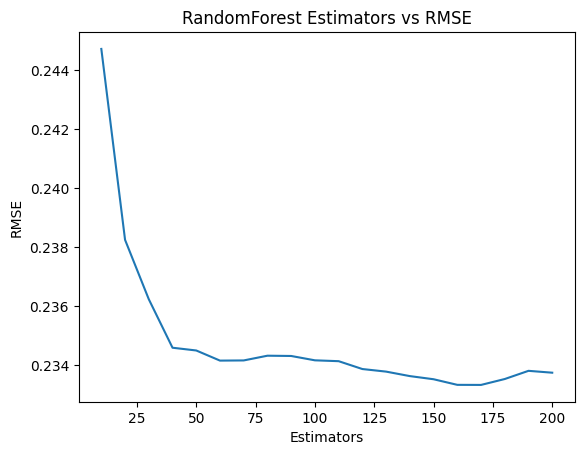

In [31]:
plt.plot(df_scores_result.n_estimators, df_scores_result.rmse)
plt.title('RandomForest Estimators vs RMSE')
plt.xlabel('Estimators')
plt.ylabel('RMSE')
plt.show()

#### Answer -> **160**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [32]:
max_depth_list =  [10, 15, 20, 25]

In [36]:
new_scores = []
for md in [10, 15, 20, 25]:
    for i in range(10, 201, 10):
        temp_rfr = RandomForestRegressor(n_estimators=i, max_depth=md, random_state=1, n_jobs=1)
        temp_model_rfr = temp_rfr.fit(X_train,y_train)
        y_pred_temp = temp_model_rfr.predict(X_val)
        new_scores.append((i, md,np.sqrt(mean_squared_error(y_val, y_pred_temp))))

In [37]:
df_q4_scores = pd.DataFrame(new_scores, columns=['n_estimators', 'max_depth','rmse'])
df_q4_scores

,n_estimators,max_depth,rmse
0,10,10,0.250510
1,20,10,0.247259
2,30,10,0.246262
3,40,10,0.245086
4,50,10,0.245621
...,...,...,...
75,160,25,0.233401
76,170,25,0.233398
77,180,25,0.233630
78,190,25,0.233886


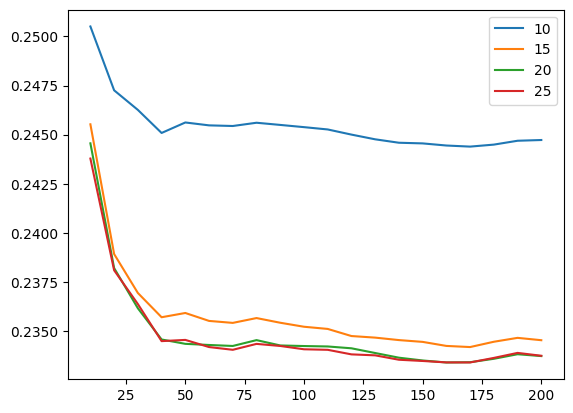

In [39]:
for d in [10, 15, 20, 25]:
    df_subset = df_q4_scores[df_q4_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

#### Answer -> **25**

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`

In [40]:
rfr_q5 = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

In [41]:
rfr_q5.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [42]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rfr_q5.feature_importances_
df_importances.sort_values('importance', ascending=False)

,feature,importance
4,median_income,0.335507
5,ocean_proximity=<1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
2,latitude,0.102717
3,longitude,0.085791
1,housing_median_age,0.030043
7,population,0.028212
9,total_rooms,0.021319
8,total_bedrooms,0.015228
0,households,0.014905


#### Answer -> **median_income**

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same

In [43]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [44]:
import xgboost as xgb

In [46]:
features = dv.get_feature_names_out()

In [47]:
features = [i.replace("=<", "_").replace("=","_") for i in features]

#### Create DMatrix for train and validation

In [48]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

#### Create a watchlist

In [49]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

#### Train a model with these parameters for 100 rounds:

In [54]:
%%capture output
xgb_model_1 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [55]:
#@ DEFINING THE FUNCTION: Taken from Notebook week 6
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [56]:
scores['eta=0.3'] = parse_xgb_output(output)

In [57]:
scores['eta=0.3']

,num_iter,train_auc,val_auc
0,0,0.44350,0.44250
1,1,0.36599,0.36916
2,2,0.31556,0.32382
3,3,0.28541,0.29965
4,4,0.26573,0.28417
...,...,...,...
95,95,0.11211,0.22908
96,96,0.11139,0.22875
97,97,0.11089,0.22864
98,98,0.11041,0.22868


In [58]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [59]:
%%capture output
xgb_model_2 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [60]:
scores['eta=0.1'] = parse_xgb_output(output)

In [61]:
scores['eta=0.1']

,num_iter,train_auc,val_auc
0,0,0.52449,0.52045
1,1,0.48736,0.48443
2,2,0.45433,0.45293
3,3,0.42533,0.42550
4,4,0.39987,0.40144
...,...,...,...
95,95,0.16562,0.23276
96,96,0.16524,0.23266
97,97,0.16444,0.23246
98,98,0.16383,0.23222


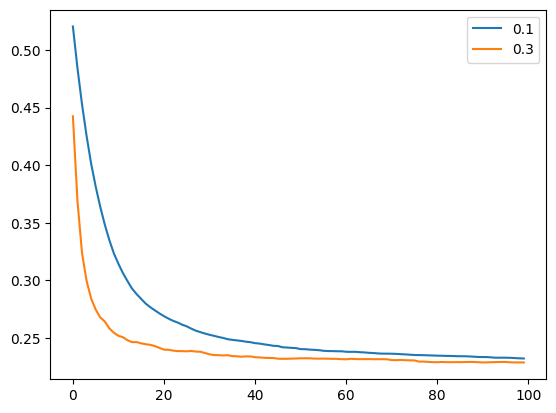

In [62]:
#@ INSPECTION:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()

#### Answer -> *0.3*